# Selecor Table Outline

In [42]:
%load_ext autoreload
%autoreload 2
fetch_download_path = '/data/fetched_from_attach'


import datajoint as dj


dj.config["enable_python_native_blobs"] = True
dj.config['schema_name'] = "nnfabrik_toy_V4"
schema = dj.schema("nnfabrik_toy_V4")

from matplotlib import pyplot as plt
from torch import load

from nnfabrik.main import *
import nnfabrik
from nnfabrik import main, builder
import os
from os import listdir
from os.path import isfile, join
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mei import mixins
import nnvision
from nnvision.tables.main import Recording
from nnvision.tables.from_nnfabrik import DataInfo, TrainedModel, TrainedHyperModel, TrainedTransferModel
from nnvision.tables.from_mei import MEI, MEIShared, MEISeed, Method, Ensemble, SharedReadoutTrainedEnsembleModel, MethodGroup


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
model = Ensemble().load_model(dict(ensemble_hash='c7cfccb056cebf84ed902b78937a391b'), include_dataloader=False)

In [25]:
mei_paths = []
texture_paths = []

augmented_mei_paths = []
augmented_texture_paths = []

unit_indices = []
data_keys = []
model_indices = []

total_unit_index = 0
model_unit_index = 0

for data_key, readout in model.members[0].readout.items():
    for i in tqdm(range(readout.outdims - 32)):
        unit_key = dict(unit_index=i, data_key=data_key, dataset_hash='ca53b3ae60291b7d55edd85b2a3b67ec')
        unit_id = (Recording.Units & unit_key).fetch1("unit_id")
        mei_paths.append(((Recording.Units*MEI&dict(ensemble_hash='c7cfccb056cebf84ed902b78937a391b', method_hash='0797aa2784bdd350da556278c0f25fcf')) & unit_key).fetch1("mei", download_path=fetch_download_path))
        
        unit_indices.append(i)
        data_keys.append(data_key)
        model_indices.append(model_unit_index)
        
        unit_hash_single_texture = (MEITargetUnits & f"unit_comment='{data_key}, unit_id={unit_id}, unit_index={i}'").fetch1("unit_hash")
        texture_key = dict(ensemble_hash='c7cfccb056cebf84ed902b78937a391b',
                    unit_hash=unit_hash_single_texture, 
                   target_hash='d41d8cd98f00b204e9800998ecf8427e',
                  method_hash='76394268b3e3d7668ac8420426725b35',
                  mei_seed=10)
        texture_paths.append((MEITextures&texture_key).fetch1("mei",download_path=fetch_download_path))
        
        
        unit_hash_single_texture = (MEITargetUnits & f"unit_comment='augmentation, 5x5, unit_index={total_unit_index}'").fetch1("unit_hash")
        texture_key = dict(ensemble_hash='5819457fd546db900f0db3e5cd903475',
            unit_hash=unit_hash_single_texture, 
           target_hash='708503aca7922d6e4b371656915a37fe',
          method_hash='39dae9406b38011b6059e3b06ee8a1a7',
          mei_seed=10)
        augmented_texture_paths.append(((MEIPrototype&texture_key)).fetch1("mei",download_path=fetch_download_path))
        
        
        unit_hash_single_texture = (MEITargetUnits & f"unit_comment='augmentation, 5x5, unit_index={total_unit_index}'").fetch1("unit_hash")
        texture_key = dict(ensemble_hash='5819457fd546db900f0db3e5cd903475',
            unit_hash=unit_hash_single_texture, 
           target_hash='708503aca7922d6e4b371656915a37fe',
          method_hash='87a9feece9fd0dda00d3f927035d9fab',
          mei_seed=10)
        augmented_mei_paths.append(((MEIPrototype&texture_key)).fetch1("mei",download_path=fetch_download_path))
        
        total_unit_index += 1
        model_unit_index += 1
    
    model_unit_index += 32
    

all_MEIs=([torch.load(i).detach().cpu().numpy().squeeze() for i in mei_paths])
texture_MEIs=([torch.load(i).detach().cpu().numpy().squeeze() for i in texture_paths])
augmented_texture_MEIs=([torch.load(i).detach().cpu().numpy().squeeze() for i in augmented_texture_paths])
augmented_MEIs=([torch.load(i).detach().cpu().numpy().squeeze() for i in augmented_mei_paths])

tensor_all_MEIs=([torch.load(i).detach().cuda() for i in mei_paths])
tensor_texture_MEIs=([torch.load(i).detach().cuda() for i in texture_paths])
tensor_augmented_texture_MEIs=([torch.load(i).detach().cuda() for i in augmented_texture_paths])
tensor_augmented_MEIs=([torch.load(i).detach().cuda() for i in augmented_mei_paths])


100%|██████████| 14/14 [00:02<00:00,  6.33it/s]


In [27]:
import scipy
from scipy import ndimage
from skimage import morphology


def generate_mask(mei, gaussian_sigma=1, zscore_thresh=.25, closing_iters=2, return_centroids=False):
    
    if type(mei) == torch.Tensor:
        mei = mei.detach().cpu().numpy().squeeze()
        is_tensor = True
    
    norm_mei = (mei - mei.mean()) / mei.std()
    thresholded = np.abs(norm_mei) > zscore_thresh
    
    # Remove small holes in the thresholded image and connect any stranding pixels
    closed = ndimage.binary_closing(thresholded, iterations=closing_iters)
    # Remove any remaining small objects
    labeled = morphology.label(closed, connectivity=2)
    most_frequent = np.argmax(np.bincount(labeled.ravel())[1:]) + 1
    oneobject = labeled == most_frequent
    # Create convex hull just to close any remaining holes and so it doesn't look weird

    hull = morphology.convex_hull_image(oneobject)
    # Smooth edges
    smoothed = ndimage.gaussian_filter(hull.astype(np.float32), sigma=gaussian_sigma)
    mask = smoothed  # final mask
    if not return_centroids:
        return torch.tensor(mask)[None, None, ...].cuda() if is_tensor else mask
    # Compute mask centroid
    px_y, px_x = (coords.mean() + 0.5 for coords in np.nonzero(hull))
    mask_y, mask_x = px_y - mask.shape[0] / 2, px_x - mask.shape[1] / 2
    # Compute MEI std inside the mask
    mei_mean = (mei * mask).sum() / mask.sum()
    mei_std = np.sqrt((((mei - mei_mean) ** 2) * mask).sum() / mask.sum())

    return mask, px_x, px_y, mask_x, mask_y

# Mask Done

# Build the Experiments

### 1. Get model

In [29]:
dataloaders, model = Ensemble().load_model(dict(ensemble_hash='c7cfccb056cebf84ed902b78937a391b'))
model.eval();
model.cuda();

### 2. Get Images

In [30]:
mei_paths = []
texture_paths = []

augmented_mei_paths = []
augmented_texture_paths = []

unit_indices = []
unit_ids = []
data_keys = []
model_indices = []

total_unit_index = 0

for data_key, readout in model.members[0].readout.items():
    for i in tqdm(range(readout.outdims-32)):
        unit_key = dict(unit_index=i, data_key=data_key, dataset_hash='ca53b3ae60291b7d55edd85b2a3b67ec')
        unit_id = (Recording.Units & unit_key).fetch1("unit_id")
        unit_ids.append(unit_id)
        mei_paths.append(((Recording.Units*MEI&dict(ensemble_hash='c7cfccb056cebf84ed902b78937a391b', method_hash='0797aa2784bdd350da556278c0f25fcf')) & unit_key).fetch1("mei", download_path=fetch_download_path))
        
        unit_indices.append(i)
        data_keys.append(data_key)
        model_indices.append(model_unit_index)
        
        unit_hash_single_texture = (MEITargetUnits & f"unit_comment='{data_key}, unit_id={unit_id}, unit_index={i}'").fetch1("unit_hash")
        texture_key = dict(ensemble_hash='c7cfccb056cebf84ed902b78937a391b',
                    unit_hash=unit_hash_single_texture, 
                   target_hash='d41d8cd98f00b204e9800998ecf8427e',
                  method_hash='76394268b3e3d7668ac8420426725b35',
                  mei_seed=10)
        texture_paths.append((MEITextures&texture_key).fetch1("mei",download_path=fetch_download_path))
        
        
        unit_hash_single_texture = (MEITargetUnits & f"unit_comment='augmentation, 5x5, unit_index={total_unit_index}'").fetch1("unit_hash")
        texture_key = dict(ensemble_hash='5819457fd546db900f0db3e5cd903475',
            unit_hash=unit_hash_single_texture, 
           target_hash='708503aca7922d6e4b371656915a37fe',
          method_hash='39dae9406b38011b6059e3b06ee8a1a7',
          mei_seed=10)
        augmented_texture_paths.append(((MEIPrototype&texture_key)).fetch1("mei",download_path=fetch_download_path))
        
        
        unit_hash_single_texture = (MEITargetUnits & f"unit_comment='augmentation, 5x5, unit_index={total_unit_index}'").fetch1("unit_hash")
        texture_key = dict(ensemble_hash='5819457fd546db900f0db3e5cd903475',
            unit_hash=unit_hash_single_texture, 
           target_hash='708503aca7922d6e4b371656915a37fe',
          method_hash='87a9feece9fd0dda00d3f927035d9fab',
          mei_seed=10)
        augmented_mei_paths.append(((MEIPrototype&texture_key)).fetch1("mei",download_path=fetch_download_path))
        
        total_unit_index += 1
        model_unit_index += 1
        

all_MEIs=([torch.load(i).detach().cpu().numpy().squeeze() for i in mei_paths])
texture_MEIs=([torch.load(i).detach().cpu().numpy().squeeze() for i in texture_paths])
augmented_texture_MEIs=([torch.load(i).detach().cpu().numpy().squeeze() for i in augmented_texture_paths])
augmented_MEIs=([torch.load(i).detach().cpu().numpy().squeeze() for i in augmented_mei_paths])

tensor_all_MEIs=[torch.load(i).detach().cuda() for i in mei_paths]
tensor_texture_MEIs=[torch.load(i).detach().cuda() for i in texture_paths]
tensor_augmented_texture_MEIs=[torch.load(i).detach().cuda() for i in augmented_texture_paths]
tensor_augmented_MEIs=[torch.load(i).detach().cuda() for i in augmented_mei_paths]

unit_indices = np.array(unit_indices)
data_keys = np.array(data_keys)
unit_ids=np.array(unit_ids)

100%|██████████| 14/14 [00:02<00:00,  6.20it/s]


# Building the full loop

In [33]:
def get_crops(mei, img_dim, edge_px):
    crops = torch.ones(edge_px*edge_px,1,img_dim,img_dim).cuda()

    img_index = 0
    for y in range(edge_px//2,int(3/2*edge_px)):
        for x in range(edge_px//2,int(3/2*edge_px)):
            crops[img_index] = mei[:, :, x:(x+img_dim), y:(y+img_dim)]
            img_index+=1
    return crops

# To Do - Other Cropped

In [ ]:
other_texture_responses_cropped, other_augmented_texture_responses_cropped  = [],[]
other_texture_responses_cropped_masked, other_augmented_texture_responses_cropped_masked  = [],[]


# Own

In [34]:
own_mei_responses, own_augmented_mei_responses, own_texture_responses, own_augmented_texture_responses  = [],[],[],[]
own_augmented_mei_responses_masked, own_texture_responses_masked, own_augmented_texture_responses_masked  = [],[],[]
own_texture_responses_cropped, own_augmented_texture_responses_cropped  = [],[]
own_texture_responses_cropped_masked, own_augmented_texture_responses_cropped_masked  = [],[]

own_texture_responses_cropped_max, own_texture_responses_cropped_max_img = [],[]
own_augmented_texture_responses_cropped_max, own_augmented_texture_responses_cropped_max_img = [],[]
own_texture_responses_cropped_masked_max, own_texture_responses_cropped_masked_max_img = [],[]
own_augmented_texture_responses_cropped_masked_max, own_augmented_texture_responses_cropped_masked_max_img = [],[]

masks = []

with torch.no_grad():
    for i in tqdm(range(len(tensor_all_MEIs))):

        mei = tensor_all_MEIs[i]
        augmented_mei = tensor_augmented_MEIs[i]
        mei_shape = mei.shape[2:]
        
        texture_mei = tensor_texture_MEIs[i]
        texture_shape = texture_mei.shape[2:]
        
        augmented_texture_mei = tensor_augmented_texture_MEIs[i]
        augmented_texture_shape = augmented_texture_mei.shape[2:]
        
        texture_crop = int((texture_shape[0]-mei_shape[0])/2)
        aug_texture_crop = int((augmented_texture_shape[0]-mei_shape[0])/2)
        
        mask = generate_mask(mei, zscore_thresh=0.5, closing_iters=2)
        masks.append(mask.detach().cpu().numpy().squeeze())
        
        own_mei_responses.append(model(mei, data_key=data_keys[i])[0][unit_indices[i]].item())
        own_augmented_mei_responses.append(model(augmented_mei, data_key=data_keys[i])[0][unit_indices[i]].item())
        own_texture_responses.append(model(texture_mei[:,:,texture_crop:-texture_crop, texture_crop:-texture_crop], data_key=data_keys[i])[0][unit_indices[i]].item())
        own_augmented_texture_responses.append(model(augmented_texture_mei[:,:,aug_texture_crop:-aug_texture_crop, aug_texture_crop:-aug_texture_crop], data_key=data_keys[i])[0][unit_indices[i]].item())

        own_augmented_mei_responses_masked.append(model(augmented_mei*mask, data_key=data_keys[i])[0][unit_indices[i]].item())
        own_texture_responses_masked.append(model(texture_mei[:,:,texture_crop:-texture_crop, texture_crop:-texture_crop]*mask, data_key=data_keys[i])[0][unit_indices[i]].item())
        own_augmented_texture_responses_masked.append(model(augmented_texture_mei[:,:,aug_texture_crop:-aug_texture_crop, aug_texture_crop:-aug_texture_crop]*mask, data_key=data_keys[i])[0][unit_indices[i]].item())
        
        # get crops
        texture_crops = get_crops(texture_mei, img_dim=67, edge_px=texture_crop)
        augmented_texture_crops = get_crops(augmented_texture_mei, img_dim=67, edge_px=aug_texture_crop)
        
        
        # get all activations of texture crops
        output = model(texture_crops, data_key=data_keys[i])[:,unit_indices[i]].detach().cpu().numpy()
        own_texture_responses_cropped.append(output)
        own_texture_responses_cropped_max.append(output.max())
        own_texture_responses_cropped_max_img.append(texture_crops[np.argmax(output)])
        
        output = model(augmented_texture_crops, data_key=data_keys[i])[:,unit_indices[i]].detach().cpu().numpy()
        own_augmented_texture_responses_cropped.append(output)
        own_augmented_texture_responses_cropped_max.append(output.max())
        own_augmented_texture_responses_cropped_max_img.append(augmented_texture_crops[np.argmax(output)])
        
        output = model(texture_crops * mask, data_key=data_keys[i])[:,unit_indices[i]].detach().cpu().numpy()
        own_texture_responses_cropped_masked.append(output)
        own_texture_responses_cropped_masked_max.append(output.max())
        own_texture_responses_cropped_masked_max_img.append(texture_crops[np.argmax(output)])
                
        output = model(augmented_texture_crops * mask, data_key=data_keys[i])[:,unit_indices[i]].detach().cpu().numpy()
        own_augmented_texture_responses_cropped_masked.append(output)
        own_augmented_texture_responses_cropped_masked_max.append(output.max())
        own_augmented_texture_responses_cropped_masked_max_img.append(augmented_texture_crops[np.argmax(output)])

100%|██████████| 254/254 [04:25<00:00,  1.04s/it]


# Other 

In [36]:
other_mei_response, other_augmented_mei_responses, other_texture_responses, other_augmented_texture_responses  = [],[],[],[]
other_augmented_mei_responses_masked, other_texture_responses_masked, other_augmented_texture_responses_masked  = [],[],[]

other_mei_img, other_augmented_mei_img,other_texture_img, other_augmented_texture_img = [],[],[],[]
other_augmented_mei_img_masked, other_texture_img_masked, other_augmented_texture_img_masked  = [],[],[]

_, idx = np.unique(data_keys, return_index=True)
original_sorted_keys = data_keys[np.sort(idx)]


with torch.no_grad():
    for data_key in tqdm(original_sorted_keys):
        tensor_masks= []

        mei = torch.stack(tensor_all_MEIs, dim=0)[:,0,...][[data_keys!=data_key]]
        augmented_mei = torch.stack(tensor_augmented_MEIs, dim=0)[:,0,...][[data_keys!=data_key]]
        texture_mei = torch.stack(tensor_texture_MEIs, dim=0)[:,0,...][[data_keys!=data_key]]
        augmented_texture_mei = torch.stack(tensor_augmented_texture_MEIs, dim=0)[:,0,...][[data_keys!=data_key]]

        for single_mei in mei:
            mask = generate_mask(single_mei[None, ...], zscore_thresh=0.5, closing_iters=2)
            tensor_masks.append(mask)
        tensor_masks = torch.stack(tensor_masks, dim=0)[:,0,...]

        outputs = model(mei, data_key=data_key)
        for i in range(sum(data_keys==data_key)):
            other_mei_response.append(outputs[:,i].max().item())
            other_mei_img.append(mei[torch.argmax(outputs[:,i])].detach().cpu().numpy().squeeze())
            
        outputs = model(augmented_mei, data_key=data_key)
        for i in range(sum(data_keys==data_key)):
            other_augmented_mei_responses.append(outputs[:,i].max().item())
            other_augmented_mei_img.append(augmented_mei[torch.argmax(outputs[:,i])].detach().cpu().numpy().squeeze())
            
        outputs = model(texture_mei[:,:,texture_crop:-texture_crop, texture_crop:-texture_crop], data_key=data_key)
        for i in range(sum(data_keys==data_key)):
            other_texture_responses.append(outputs[:,i].max().item())
            other_texture_img.append(texture_mei[torch.argmax(outputs[:,i])].detach().cpu().numpy().squeeze())
            
        outputs = model(augmented_texture_mei[:,:,aug_texture_crop:-aug_texture_crop, aug_texture_crop:-aug_texture_crop], data_key=data_key)
        for i in range(sum(data_keys==data_key)):
            other_augmented_texture_responses.append(outputs[:,i].max().item())
            other_augmented_texture_img.append(augmented_texture_mei[torch.argmax(outputs[:,i])].detach().cpu().numpy().squeeze())
    
        
        # augmented MEI masked
        outputs = model(augmented_mei*tensor_masks, data_key=data_key)
        for i in range(sum(data_keys==data_key)):
            other_augmented_mei_responses_masked.append(outputs[:,i].max().item())
            other_augmented_mei_img_masked.append(mei[torch.argmax(outputs[:,i])].detach().cpu().numpy().squeeze())
        
        # texture masked
        outputs = model(texture_mei[:,:,texture_crop:-texture_crop, texture_crop:-texture_crop] * tensor_masks, data_key=data_key)
        for i in range(sum(data_keys==data_key)):
            other_texture_responses_masked.append(outputs[:,i].max().item())
            other_texture_img_masked.append(mei[torch.argmax(outputs[:,i])].detach().cpu().numpy().squeeze())
            
        # augmented texture masked
        outputs = model(augmented_texture_mei[:,:,aug_texture_crop:-aug_texture_crop, aug_texture_crop:-aug_texture_crop] * tensor_masks, data_key=data_key)
        for i in range(sum(data_keys==data_key)):
            other_augmented_texture_responses_masked.append(outputs[:,i].max().item())
            other_augmented_texture_img_masked.append(mei[torch.argmax(outputs[:,i])].detach().cpu().numpy().squeeze())
        
        

100%|██████████| 31/31 [00:44<00:00,  1.45s/it]


# Self Analysis

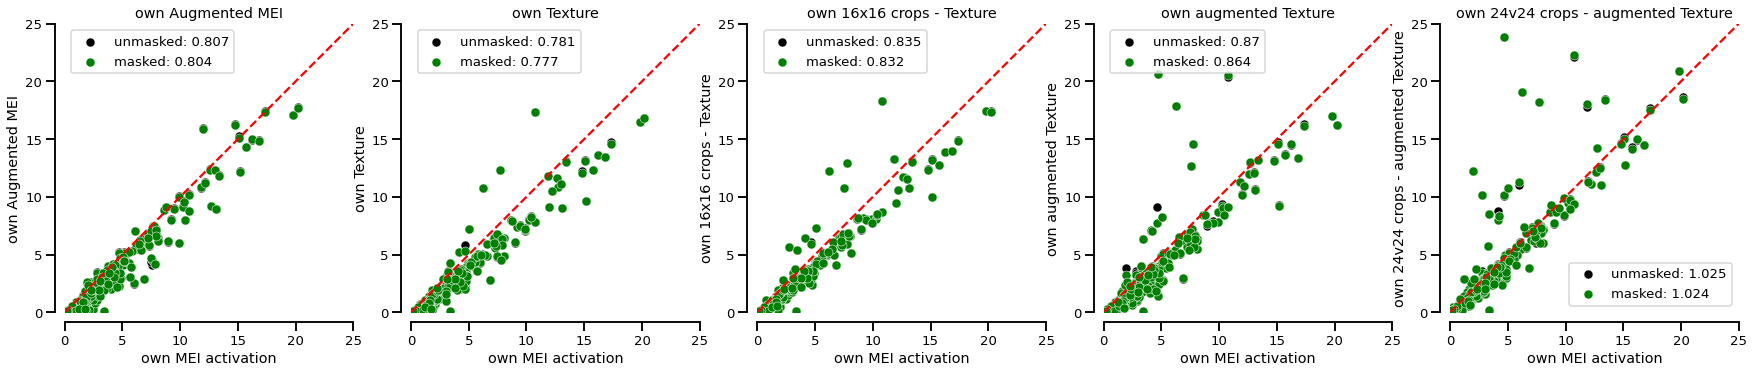

In [37]:
sns.set_context(context='talk', font_scale=0.8)

fig, axs = plt.subplots(1,5, figsize=(30,6))

titles = ["own Augmented MEI", "own Texture", "own 16x16 crops - Texture", "own augmented Texture", "own 24v24 crops - augmented Texture"]
var_list = [own_augmented_mei_responses, own_texture_responses, own_texture_responses_cropped_max, own_augmented_texture_responses, own_augmented_texture_responses_cropped_max]
var_list_masked = [own_augmented_mei_responses_masked, own_texture_responses_masked, own_texture_responses_cropped_masked_max, own_augmented_texture_responses_masked, own_augmented_texture_responses_cropped_masked_max]

for i, ax in enumerate(axs.ravel()):

    activation = np.sum(var_list[i]) / np.sum(own_mei_responses)
    ax.scatter(own_mei_responses, var_list[i], edgecolors='w', linewidths=.5, color='k', label='unmasked: '+ str(np.round(activation,3)))
    activation = np.sum(var_list_masked[i]) / np.sum(own_mei_responses)
    ax.scatter(own_mei_responses, var_list_masked[i],edgecolors='w', linewidths=.5, color='g', label='masked: '+ str(np.round(activation,3)))
    ax.set_aspect("equal")
    ax.set_xlim([0,25])
    ax.set_ylim([0,25])

    ax.set_xlabel("own MEI activation")
    ax.set_ylabel(titles[i])

    ax.plot([0,25], [0,25], 'r--')
    ax.legend();

    ax.set_title(titles[i])
sns.despine(trim=True, offset=10)

# plt.savefig("Own_Textures_Comparison.png", dpi=100,bbox_inches="tight")

### Self vs other

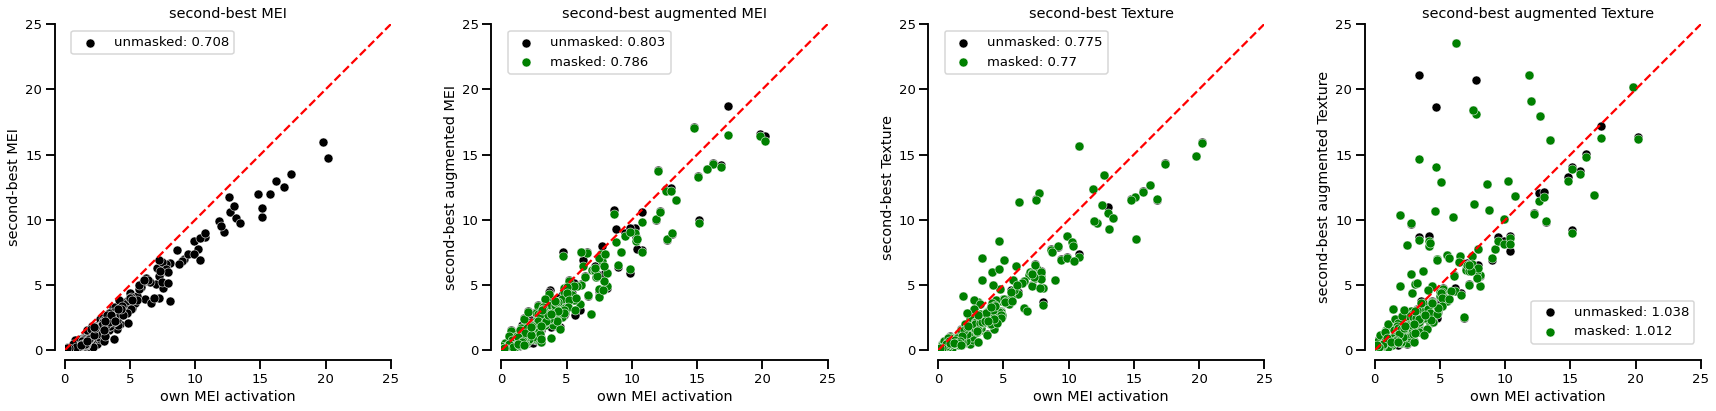

In [38]:
sns.set_context(context='talk', font_scale=0.8)

fig, axs = plt.subplots(1,4, figsize=(30,6))

titles = ["second-best MEI", "second-best augmented MEI", "second-best Texture", "second-best augmented Texture"]
var_list = [other_mei_response, other_augmented_mei_responses, other_texture_responses, other_augmented_texture_responses]
var_list_masked = [0, other_augmented_mei_responses_masked, other_texture_responses_masked, other_augmented_texture_responses_masked]

for i, ax in enumerate(axs.ravel()):

    activation = np.sum(var_list[i]) / np.sum(own_mei_responses)
    ax.scatter(own_mei_responses, var_list[i], edgecolors='w', linewidths=.5, color='k', label='unmasked: '+ str(np.round(activation,3)))
    if i > 0:
        activation = np.sum(var_list_masked[i]) / np.sum(own_mei_responses)
        ax.scatter(own_mei_responses, var_list_masked[i],edgecolors='w', linewidths=.5, color='g', label='masked: '+ str(np.round(activation,3)))
    ax.set_aspect("equal")
    ax.set_xlim([0,25])
    ax.set_ylim([0,25])

    ax.set_xlabel("own MEI activation")
    ax.set_ylabel(titles[i])

    ax.plot([0,25], [0,25], 'r--')
    ax.legend();

    ax.set_title(titles[i])
sns.despine(trim=True, offset=10)

#plt.savefig("Second_Best_Textures.png", dpi=100,bbox_inches="tight")

# Detailed Plot for all Neurons

In [ ]:
for plots in range(21):


    fig, axs = plt.subplots(12,12, figsize=(30, 35))

    offset = 12*plots

    for i in range(12):
        for j in range(12):

            if j == 0:
                axs[i,j].imshow(all_MEIs[i+offset], cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("MEI \n" + "Mei Act = " +str(round(own_mei_responses[i+offset])))
                else:
                    axs[i,j].set_title("Mei Act = " +str(round(own_mei_responses[i+offset],1)))

            if j == 1:
                axs[i,j].imshow(augmented_MEIs[i+offset], cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("Augmented MEI \n" + "% Act = " +str(round(1/own_mei_responses[i+offset]*100* own_augmented_mei_responses[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* own_augmented_mei_responses[i+offset], 1)))


            if j == 2:
                axs[i,j].imshow(texture_MEIs[i+offset], cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                rect = patches.Rectangle((16,16),67,67 ,linewidth=1,edgecolor='k',facecolor='none')
                axs[i,j].add_patch(rect)
                if i == 0:
                    axs[i,j].set_title("Texture \n" + "Mei Act = " +str(round(1/own_mei_responses[i+offset]*100* own_texture_responses[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* own_texture_responses[i+offset], 1)))

            if j == 3:
                axs[i,j].imshow(augmented_texture_MEIs[i+offset], cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                rect = patches.Rectangle((24,24),67,67 ,linewidth=1,edgecolor='k',facecolor='none')
                axs[i,j].add_patch(rect)
                if i == 0:
                    axs[i,j].set_title("Aug Texture \n" + "% Act = " +str(round(1/own_mei_responses[i+offset]/ own_augmented_texture_responses[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* own_augmented_texture_responses[i+offset], 1)))

            if j == 4:
                axs[i,j].imshow(own_texture_responses_cropped_max_img[i+offset].detach().cpu().numpy().squeeze(), cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("Tex Best Crop \n" + "% Act = " +str(round(1/own_mei_responses[i+offset]*100* own_texture_responses_cropped_max[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* own_texture_responses_cropped_max[i+offset], 1)))

            if j == 5:
                axs[i,j].imshow(own_texture_responses_cropped[i+offset].reshape(16,16).T, cmap="hot")
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("Tex Activation")

            if j == 6:
                axs[i,j].imshow(own_augmented_texture_responses_cropped_max_img[i+offset].detach().cpu().numpy().squeeze(), cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("Aug. Tex Best Crop \n" + "% Act = " +str(round(1/own_mei_responses[i+offset]*100* own_augmented_texture_responses_cropped_max[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* own_augmented_texture_responses_cropped_max[i+offset], 1)))

            if j == 7:
                axs[i,j].imshow(own_augmented_texture_responses_cropped[i+offset].reshape(24,24).T, cmap="hot")
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("Aug Tex Activation")

            if j == 8:
                axs[i,j].imshow(other_mei_img[i+offset], cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("2nd Best MEI \n" + "% Act = " +str(round(1/own_mei_responses[i+offset]*100* other_mei_response[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* other_mei_response[i+offset], 1)))

            if j == 9:
                axs[i,j].imshow(other_augmented_mei_img[i+offset], cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("2nd Best Aug MEI \n" + "% Act = " +str(round(1/own_mei_responses[i+offset]*100* other_augmented_mei_responses[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* other_augmented_mei_responses[i+offset], 1)))

            if j == 10:
                axs[i,j].imshow(other_texture_img[i+offset], cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("2nd Best Texture \n" + "% Act = " +str(round(1/own_mei_responses[i+offset]*100* other_texture_responses[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* other_texture_responses[i+offset], 1)))

            if j == 11:
                axs[i,j].imshow(other_augmented_texture_img[i+offset], cmap="gray", vmin=-1.7, vmax=2.2)
                axs[i,j].axis("off")
                if i == 0:
                    axs[i,j].set_title("2nd Best Aug Texture \n" + "% Act = " +str(round(1/own_mei_responses[i+offset]*100* other_augmented_texture_responses[i+offset], 1)))
                else:
                    axs[i,j].set_title("% Act = " +str(round(1/own_mei_responses[i+offset]*100* other_augmented_texture_responses[i+offset], 1)))

    plt.savefig(f"MEI_2nd_best_comparison_{plots}.png", dpi=100, bbox_inches="tight")

# Create the Mask Cutoff Plot

In [39]:
own_mei_responses, masked_mei, own_texture_responses, own_augmented_texture_responses  = [],[],[],[]
own_augmented_mei_responses_masked, own_texture_responses_masked, own_augmented_texture_responses_masked  = [],[],[]
own_texture_responses_cropped, own_augmented_texture_responses_cropped  = [],[]
own_texture_responses_cropped_masked, own_augmented_texture_responses_cropped_masked  = [],[]

other_augmented_mei_responses, other_texture_responses, other_augmented_texture_responses  = [],[],[]
other_augmented_mei_responses_masked, other_texture_responses_masked, other_augmented_texture_responses_masked  = [],[],[]
other_texture_responses_cropped, other_augmented_texture_responses_cropped  = [],[]
other_texture_responses_cropped_masked, other_augmented_texture_responses_cropped_masked  = [],[]
masks = []
    
own_r = []
mask_r=[]
for gif_counter, z_thresh in enumerate(np.round(np.linspace(0.1,1.5, 15),1)):
    masks = []
    own_mei_responses, masked_mei = [],[]
    with torch.no_grad():
        for i in tqdm(range(len(tensor_all_MEIs))):

            mei = tensor_all_MEIs[i]
            augmented_mei = tensor_augmented_MEIs[i]
            mei_shape = mei.shape[2:]

            texture_mei = tensor_texture_MEIs[i]
            texture_shape = texture_mei.shape[2:]

            augmented_texture_mei = tensor_augmented_texture_MEIs[i]
            augmented_texture_shape = augmented_texture_mei.shape[2:]

            texture_crop = int((texture_shape[0]-mei_shape[0])/2)
            aug_texture_crop = int((augmented_texture_shape[0]-mei_shape[0])/2)

            mask = generate_mask(mei, zscore_thresh=z_thresh, closing_iters=2)
            masks.append(mask.detach().cpu().numpy().squeeze())

            own_mei_responses.append(model(mei, data_key=data_keys[i])[0][unit_indices[i]].item())
            masked_mei.append(model(mei*mask, data_key=data_keys[i])[0][unit_indices[i]].item())
    own_r.append(np.mean(own_mei_responses))
    mask_r.append(np.mean(masked_mei))
own_r = np.array(own_r)
mask_r = np.array(mask_r)

100%|██████████| 254/254 [00:04<00:00, 55.28it/s]


No handles with labels found to put in legend.


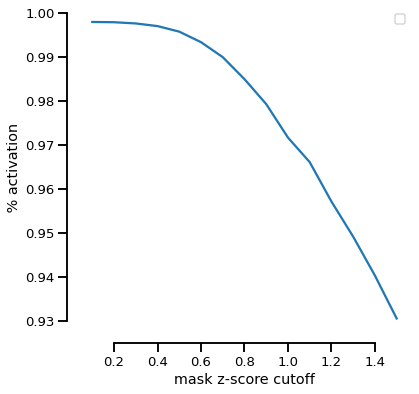

In [40]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

plt.plot(np.round(np.linspace(0.1,1.5, 15),1),mask_r/own_r)

ax.set_xlabel("mask z-score cutoff")
ax.set_ylabel("% activation")
sns.despine(trim=True, offset=10)

plt.savefig("mask_zscore_cutoff_drop.png", dpi=100, bbox_inches="tight")

# Create the Mask Gif

In [ ]:
own_mei_responses, own_augmented_mei_responses, own_texture_responses, own_augmented_texture_responses  = [],[],[],[]
own_augmented_mei_responses_masked, own_texture_responses_masked, own_augmented_texture_responses_masked  = [],[],[]
own_texture_responses_cropped, own_augmented_texture_responses_cropped  = [],[]
own_texture_responses_cropped_masked, own_augmented_texture_responses_cropped_masked  = [],[]

other_augmented_mei_responses, other_texture_responses, other_augmented_texture_responses  = [],[],[]
other_augmented_mei_responses_masked, other_texture_responses_masked, other_augmented_texture_responses_masked  = [],[],[]
other_texture_responses_cropped, other_augmented_texture_responses_cropped  = [],[]
other_texture_responses_cropped_masked, other_augmented_texture_responses_cropped_masked  = [],[]
masks = []
    

for gif_counter, z_thresh in enumerate(np.round(np.linspace(0.1,1.5, 15),1)):
    masks = []
    with torch.no_grad():
        for i in tqdm(range(len(tensor_all_MEIs))):

            mei = tensor_all_MEIs[i]
            augmented_mei = tensor_augmented_MEIs[i]
            mei_shape = mei.shape[2:]

            texture_mei = tensor_texture_MEIs[i]
            texture_shape = texture_mei.shape[2:]

            augmented_texture_mei = tensor_augmented_texture_MEIs[i]
            augmented_texture_shape = augmented_texture_mei.shape[2:]

            texture_crop = int((texture_shape[0]-mei_shape[0])/2)
            aug_texture_crop = int((augmented_texture_shape[0]-mei_shape[0])/2)

            mask = generate_mask(mei, zscore_thresh=z_thresh, closing_iters=2)
            masks.append(mask.detach().cpu().numpy().squeeze())

            if yo:
                own_mei_responses.append(model(mei, data_key=data_keys[i])[0][unit_indices[i]].item())
                own_augmented_mei_responses.append(model(augmented_mei, data_key=data_keys[i])[0][unit_indices[i]].item())
                own_texture_responses.append(model(texture_mei[:,:,texture_crop:-texture_crop, texture_crop:-texture_crop], data_key=data_keys[i])[0][unit_indices[i]].item())
                own_augmented_texture_responses.append(model(augmented_texture_mei[:,:,aug_texture_crop:-aug_texture_crop, aug_texture_crop:-aug_texture_crop], data_key=data_keys[i])[0][unit_indices[i]].item())


            #mei_shape = [16:-16, 16:-16]

            neurons_own_response = 0

    fig, axs = plt.subplots(13,20, figsize=(30,22))
    for j, ax in enumerate(axs.ravel()):
        if j >= len(masks):
            ax.axis("off")
            continue
        ax.imshow(all_MEIs[j], cmap="gray")
        ax.contour(masks[j])
        ax.axis("off")
        ax.set_title(str(z_thresh))
    plt.savefig(f"mask_gif_" + str(gif_counter).zfill(2) +".png", dpi=75, bbox_inches="tight")

In [873]:
import glob
from PIL import Image

fp_in = "/notebooks/notebooks/monkey/texture/mask_gif_*.png"
fp_out = "/notebooks/notebooks/monkey/texture/mei_mask_selection.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, 
         format='GIF',
         append_images=imgs,
         save_all=True, 
         duration=500, 
         loop=0)